In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Primera version solo blanco y negro

In [ ]:
imagenA = cv2.cvtColor(cv2.imread("Imagenes/Histogram Matching/alvarez.jpg"), cv2.COLOR_BGR2GRAY)
imagenB = cv2.cvtColor(cv2.imread("Imagenes/Histogram Matching/verstappen.jpeg"), cv2.COLOR_BGR2GRAY)

plt.imshow(imagenA, cmap='gray', vmin=0, vmax=255)

In [ ]:
plt.imshow(imagenB, cmap='gray', vmin=0, vmax=255)

calculamos histogramas

In [ ]:
histSize = 256
histRange = (0, 256) # the upper boundary is exclusive
histograma_A = cv2.calcHist(imagenA, [0], None, [histSize], histRange).flatten()
cv2.normalize( histograma_A, histograma_A)

plt.figure(0)
plt.bar(np.arange(0,256), histograma_A)
plt.show()

In [ ]:
histograma_B = cv2.calcHist(imagenB, [0], None, [histSize], histRange).flatten()
cv2.normalize( histograma_B, histograma_B)

plt.figure(0)
plt.bar(np.arange(0,256), histograma_B)
plt.show()

calculamos las distribuciones acumuladas de los histogramas

In [ ]:
acc_histo_A = histograma_A.cumsum() # np.add.accumulate(histograma_A)
cv2.normalize( acc_histo_A, acc_histo_A)
plt.figure(0)
plt.plot(np.arange(0,256), acc_histo_A, marker='None')
plt.show()

In [ ]:
acc_histo_B = np.add.accumulate(histograma_B)
cv2.normalize( acc_histo_B, acc_histo_B)
plt.figure(0)
plt.plot(np.arange(0,256), acc_histo_B, marker='None')
plt.show()

Queremos que el histograma de la imagen B (verstappen) matchee con el histograma de la imagen A (alvarez)

In [ ]:
# funcion de matcheo
M = np.zeros(256)

#Then for each gray level G1 in [0,255], we find the gray level G2 for which acc_B(G1)=acc_A(G2)
for G1 in range(256):
    G2 = np.searchsorted( acc_histo_A, acc_histo_B[G1], side="left" )
    M[G1] = np.round(G2)

imagenMatcheada = [ [ min(M[pixel], 255) for pixel in fila ] for fila in imagenB ] 


In [ ]:
plt.imshow(imagenMatcheada, cmap='gray', vmin=0, vmax=255)

In [ ]:
histograma_IM = cv2.calcHist(np.uint8(imagenMatcheada), [0], None, [histSize], histRange).flatten()
cv2.normalize( histograma_IM, histograma_IM)
acc_histo_IM = np.add.accumulate(histograma_IM)
cv2.normalize( acc_histo_IM, acc_histo_IM)

plt.figure(0)
plt.plot(np.arange(0,256), acc_histo_B, marker='None', color='red')
plt.plot(np.arange(0,256), acc_histo_IM, marker='None', color='blue')
plt.plot(np.arange(0,256), acc_histo_A, marker='None', color='orange')
plt.show()

# Matcheando imagenes similares

In [ ]:
%reset -f
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10] #modificar si queremos mayor tamano de las figuras

In [ ]:
def getPDFsCDFs( imagen ):
    canales = cv2.split( imagen )
    sizeImagen = (imagen.shape[0] * imagen.shape[1] )
    histogramas = [ np.histogram(canal, bins=256, range=(0, 256), density=True)[0] for canal in canales ]
    acumuladas = [ np.add.accumulate(histograma) for histograma in histogramas ]
    return histogramas, acumuladas

In [ ]:
imagenA = cv2.imread("Imagenes/Histogram Matching/yosemite1.jpeg")
imagenB = cv2.imread("Imagenes/Histogram Matching/yosemite2.jpeg")

# histogramas y acumuladas
histogramas_A, acumuladas_A = getPDFsCDFs(imagenA)
histogramas_B, acumuladas_B = getPDFsCDFs(imagenB)

In [ ]:
# funcion de matcheo por canal
M1 = np.zeros(256, dtype=np.uint8)
M2 = np.zeros(256, dtype=np.uint8)
M3 = np.zeros(256, dtype=np.uint8)

#Then for each gray level G1 in [0,255], we find the gray level G2 for which acc_B(G1)=acc_A(G2)
for G1 in np.arange(0,256):
    G2 = np.searchsorted( acumuladas_A[0], acumuladas_B[0][G1], side="left" )
    M1[G1] = min( np.uint8( np.round(G2) ), 255)
    
    G2 = np.searchsorted( acumuladas_A[1], acumuladas_B[1][G1], side="left" )
    M2[G1] = min( np.uint8( np.round(G2) ), 255)
    
    G2 = np.searchsorted( acumuladas_A[2], acumuladas_B[2][G1], side="left" )
    M3[G1] = min( np.uint8( np.round(G2) ), 255)

In [ ]:
# esto hacerlo asi es anos luz mas rapido que hacer un for en por toda la imagen (osea hacer split y merge)
canales_B = cv2.split( imagenB )
nuevoB = np.array( [ M1[b] for b in canales_B[0] ] )
nuevoG = np.array( [ M2[g] for g in canales_B[1] ] )
nuevoR = np.array( [ M3[r] for r in canales_B[2] ] )

imagenMatcheada = np.array([])
imagenMatcheada = cv2.merge( [nuevoB, nuevoG, nuevoR], imagenMatcheada)

In [ ]:
plt.imshow(imagenA[...,::-1])

In [ ]:
plt.imshow(imagenB[...,::-1])

In [ ]:
plt.imshow(imagenMatcheada[...,::-1])

Parecería que matcheo mas o menos bien. Hay algunos artifacts en el cielo pero zafa. Veamos que paso realmente con las acumuladas

In [ ]:
histogramas_IM, acumuladas_IM = getPDFsCDFs( imagenMatcheada )

plt.figure(0)
plt.plot( np.arange(0,256), acumuladas_A[0], marker='None', linestyle='solid', color='blue')
plt.plot( np.arange(0,256, 10), acumuladas_IM[0][np.arange(0,256, 10)], marker='.', linestyle='None', color='blue')
plt.plot( np.arange(0,256), acumuladas_B[0], marker='None', linestyle='dotted', color='blue')

plt.plot( np.arange(0,256), acumuladas_A[1], marker='None', linestyle='solid', color='green')
plt.plot( np.arange(0,256, 10), acumuladas_IM[1][np.arange(0,256, 10)], marker='.', linestyle='None', color='green')
plt.plot( np.arange(0,256), acumuladas_B[1], marker='None', linestyle='dotted', color='green')

plt.plot( np.arange(0,256), acumuladas_A[2], marker='None', linestyle='solid', color='red')
plt.plot( np.arange(0,256, 10), acumuladas_IM[2][np.arange(0,256, 10)], marker='.', linestyle='None', color='red')
plt.plot( np.arange(0,256), acumuladas_B[2], marker='None', linestyle='dotted', color='red')

plt.show()

Podemos ver en la figura que los puntos (valores de las acumuladas de la imagen matcheada) se pegan a las lineas solidas (acumuladas de imagen target), mientras que las acumuladas originales (lineas punteadas) quedan lejos.

# Multiple histogram matching:
paper: https://faculty.idc.ac.il/toky/Publications/Conference/hist_icip_13.pdf

empiezo probando version byn

In [ ]:
%reset -f
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
imagenA = cv2.cvtColor(cv2.imread("Imagenes/Histogram Matching/yosemite1.jpeg"), cv2.COLOR_BGR2GRAY)
imagenB = cv2.cvtColor(cv2.imread("Imagenes/Histogram Matching/yosemite2.jpeg"), cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(imagenA, cmap='gray', vmin=0, vmax=255)

In [ ]:
plt.imshow(imagenB, cmap='gray', vmin=0, vmax=255)

In [ ]:
descriptor = cv2.xfeatures2d.SURF_create()

(kpsA, featuresA) = descriptor.detectAndCompute(imagenA, mask=None)
(kpsB, featuresB) = descriptor.detectAndCompute(imagenB, mask=None)

ratio = 0.75

matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

#me quiero quedar con los N matcheos con mejor response en promedio
N = 10
bestMatcheos = [(0,0) for i in range(N)]
bestResponses = [0 for i in range(N)]
# 
matches = []
for (m1, m2) in rawMatches:
    if m1.distance < m2.distance * ratio:
        matches.append((m1.trainIdx, m1.queryIdx))
        
        responsePromedio = (kpsA[m1.queryIdx].response + kpsB[m1.trainIdx].response) / 2
        i = np.searchsorted(bestResponses, responsePromedio)
        bestResponses = bestResponses[:i] + [responsePromedio] + bestResponses[i:]
        bestMatcheos = bestMatcheos[:i] + [(m1.trainIdx, m1.queryIdx)] + bestMatcheos[i:]
        
        bestResponses = bestResponses[-N:]
        bestMatcheos = bestMatcheos[-N:]
        

tenemos una barbaridad de matcheos

In [ ]:
toleranciaRansac = 4

keypointsAFloatA = np.float32([kp.pt for kp in kpsA])
keypointsAFloatB = np.float32([kp.pt for kp in kpsB])

if len(matches) > 4:
    ptsA = np.float32([keypointsAFloatA[i] for (_, i) in matches])
    ptsB = np.float32([keypointsAFloatB[i] for (i, _) in matches])
    (H, inliners) = cv2.findHomography(
        ptsB, ptsA, cv2.RANSAC, toleranciaRansac)
else:
    print("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
    
result = cv2.warpPerspective(imagenB, H,
      (imagenB.shape[1] + imagenA.shape[1], imagenB.shape[0]))
result[0:imagenA.shape[0], 0:imagenA.shape[1]] = imagenA
plt.imshow(result, cmap='gray', vmin=0, vmax=255)

vemos que hay diferencias de color entre ambas fotos

In [ ]:
def tupleToInt( v ):
    return (int(v[0]), int(v[1]))

histSize = 256
histRange = (0, 256)

histogramas_A = np.zeros((N,histSize,1),dtype=np.float32)
histogramas_B = np.zeros((N,histSize,1),dtype=np.float32)
# calculamos histogramas:
for idx, matcheo in enumerate(bestMatcheos):
    maskA = np.zeros( imagenA.shape[:2], dtype=np.uint8 )
    cv2.circle(maskA, 
               tupleToInt(kpsA[matcheo[1]].pt),
               radius=int(kpsA[matcheo[1]].size / 2),
               color=255, thickness=-1)
    
    histogramas_A[idx] = cv2.calcHist([imagenA], [0], maskA, [histSize], histRange )
    cv2.normalize( histogramas_A[idx], histogramas_A[idx])
    
    maskB = np.zeros( imagenB.shape[:2], dtype=np.uint8 )
    cv2.circle(maskB, 
               tupleToInt(kpsB[matcheo[0]].pt),
               radius=int(kpsB[matcheo[0]].size / 2),
               color=255, thickness=-1)
    
    histogramas_B[idx] = cv2.calcHist([imagenB], [0], maskB, [histSize], histRange)
    cv2.normalize( histogramas_B[idx] , histogramas_B[idx])

In [ ]:
print(np.linalg.norm(histogramas_A[0]))

Usamos alguna norma matricial... para este primer intento uso la norma 1 normalita.
Se cumple que la distancia entre las dos matrices es la suma de distancias entre cada histograma.
En este caso la distancia entre cada histograma es: sum( | p_i,a - p_i,b |) con i = 1 ... 256

In [ ]:
# method puede ser 0,1,2,3
# definidos en: https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
def d(A, B, method=0):
    if len(A.shape) == 3:
        return sum( [ cv2.compareHist(A[idx], B[idx], method=method) for idx in range(N) ] )
    else:
        return  cv2.compareHist(A, B, method=method)

defino la funcion RowCost:

In [ ]:
def RowCost(A, B, i, j, k):
    return d( A[:,j:k+1].sum(axis=1), B[:, i])

In [ ]:
C = np.zeros((256, 256))
T = np.zeros((256, 256))

for (i, j) in np.ndindex(C.shape):
    if i == 0:
        C[0, j] = RowCost(histogramas_A, histogramas_B, 0, 0, j)
    else:
        costos = [ C[i-1, j_p] + RowCost(histogramas_A, histogramas_B, i, j_p + 1, j) for j_p in range(j+1) ]
        j_min = np.argmin(costos)
        
        T[i, j] = j_min
        C[i, j] = costos[j_min]

In [ ]:
# construyo M
M = np.zeros((256,256))

i, j = 255, 255
while i >= 0 and j >= 0:
    if T[i,j] < j:
        for j_p in range( int(T[i,j]) + 1, j+1):
            M[i][j_p] = 1
        j = int(T[i][j])
        
    i -= 1    

In [ ]:
for i in range(N):
    Ap = np.float32(M @ histogramas_A[i])
    print(d(histogramas_A[i], histogramas_B[i]) - d(Ap, histogramas_B[i]))

da todas distancias positivas... Osea que anduvo regio!!

soy un boludooooooooooooooooooooooo. esto no anda... o no resuelve lo que quiero en realidad.
La idea del paper es cuando podes subidividir una imagen en regiones y a cada una de esas regiones asignarle una region en la imagen objetivo. Que no es el caso en el stitch, ya que mas del 50% de la imagen no tiene correlacion con la imagen objetivo.
Ya se como poder usarlo! en el proximo episodio

# HM en stitching

Quiero hacer lo que hicimos en las imagenes de yosemite pero tomando en cuenta solo los histogramas de la region superpuesta enter las imagenes.
Nose si eso lo mejorara o que.

In [1]:
%reset -f
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
imagenA = cv2.imread("Imagenes/Histogram Matching/yosemite1.jpeg")
imagenB = cv2.imread("Imagenes/Histogram Matching/yosemite2.jpeg")

descriptor = cv2.xfeatures2d.SURF_create()

(kpsA, featuresA) = descriptor.detectAndCompute(imagenA, mask=None)
(kpsB, featuresB) = descriptor.detectAndCompute(imagenB, mask=None)

ratio = 0.75

matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

# 
matches = []
for (m1, m2) in rawMatches:
    if m1.distance < m2.distance * ratio:
        matches.append((m1.trainIdx, m1.queryIdx))

toleranciaRansac = 4

keypointsAFloatA = np.float32([kp.pt for kp in kpsA])
keypointsAFloatB = np.float32([kp.pt for kp in kpsB])

if len(matches) > 4:
    ptsA = np.float32([keypointsAFloatA[i] for (_, i) in matches])
    ptsB = np.float32([keypointsAFloatB[i] for (i, _) in matches])
    (H, inliners) = cv2.findHomography(
        ptsB, ptsA, cv2.RANSAC, toleranciaRansac)
else:
    print("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")

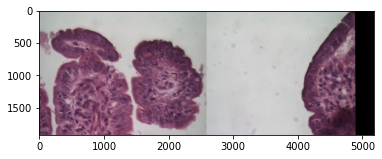

In [3]:
result = cv2.warpPerspective(imagenB, H,
      (imagenB.shape[1] + imagenA.shape[1], imagenB.shape[0]))
result[0:imagenA.shape[0], 0:imagenA.shape[1]] = imagenA
plt.imshow(result[...,::-1])

Queremos obtener una mascara de la region de superposicion entre las imagenes.
Para este primer caso voy a suponer que la imagenA no tiene bordes ni nada raro. En el pipeline posta si hay bordes y cosas feas... ahi voy a tener que ver como hacer.

In [4]:
maskA = np.ones( imagenA.shape, dtype=np.uint8 ) * 255
maskB = cv2.warpPerspective(np.ones( imagenB.shape, dtype=np.uint8 ) * 255, H, (imagenA.shape[1], imagenA.shape[0]))

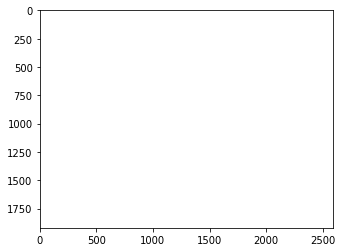

In [5]:
plt.imshow(maskA, cmap='gray', vmin=0, vmax=255)

In [ ]:
plt.imshow(maskB, cmap='gray', vmin=0, vmax=255)

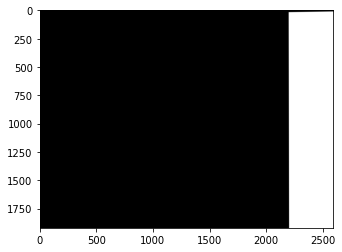

In [7]:
superposicionMask = cv2.bitwise_and(maskA, maskB)
plt.imshow(superposicionMask, cmap='gray', vmin=0, vmax=255)

In [6]:
def getPDFsCDFs( imagen, mascara=None ):
    canales = cv2.split( imagen )
    
    if mascara is None:
        histogramas = [ np.histogram(canal, bins=256, range=(0, 256), density=True)[0] for canal in canales ]
    else:
        canalesMask = cv2.split( mascara )
        histogramas = [ np.histogram(canal[canalesMask[idx] == 255], bins=256, range=(0, 256), density=True)[0] for idx, canal in enumerate(canales) ]
        
    acumuladas = [ np.add.accumulate(histograma) for histograma in histogramas ]
    return histogramas, acumuladas

In [8]:
histogramas_A, acumuladas_A = getPDFsCDFs(imagenA, superposicionMask)
histogramas_B, acumuladas_B = getPDFsCDFs(cv2.warpPerspective(imagenB, H, (imagenA.shape[1], imagenA.shape[0])), superposicionMask)

In [9]:
# funcion de matcheo por canal
M1 = np.zeros(256, dtype=np.uint8)
M2 = np.zeros(256, dtype=np.uint8)
M3 = np.zeros(256, dtype=np.uint8)

#Then for each gray level G1 in [0,255], we find the gray level G2 for which acc_B(G1)=acc_A(G2)
for G1 in np.arange(0,256):
    G2 = np.searchsorted( acumuladas_A[0], acumuladas_B[0][G1], side="left" )
    M1[G1] = min( np.uint8( np.round(G2) ), 255)
    
    G2 = np.searchsorted( acumuladas_A[1], acumuladas_B[1][G1], side="left" )
    M2[G1] = min( np.uint8( np.round(G2) ), 255)
    
    G2 = np.searchsorted( acumuladas_A[2], acumuladas_B[2][G1], side="left" )
    M3[G1] = min( np.uint8( np.round(G2) ), 255)

In [10]:
# esto hacerlo asi es anos luz mas rapido que hacer un for en por toda la imagen (osea hacer split y merge)
canales_B = cv2.split( imagenB )
nuevoB = np.array( [ M1[b] for b in canales_B[0] ] )
nuevoG = np.array( [ M2[g] for g in canales_B[1] ] )
nuevoR = np.array( [ M3[r] for r in canales_B[2] ] )

imagenMatcheada = np.array([])
imagenMatcheada = cv2.merge( [nuevoB, nuevoG, nuevoR], imagenMatcheada)

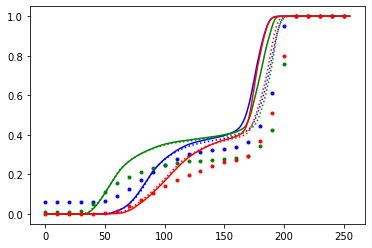

In [11]:
histogramas_IM, acumuladas_IM = getPDFsCDFs( imagenMatcheada )

plt.figure(0)
plt.plot( np.arange(0,256), acumuladas_A[0], marker='None', linestyle='solid', color='blue')
plt.plot( np.arange(0,256, 10), acumuladas_IM[0][np.arange(0,256, 10)], marker='.', linestyle='None', color='blue')
plt.plot( np.arange(0,256), acumuladas_B[0], marker='None', linestyle='dotted', color='blue')

plt.plot( np.arange(0,256), acumuladas_A[1], marker='None', linestyle='solid', color='green')
plt.plot( np.arange(0,256, 10), acumuladas_IM[1][np.arange(0,256, 10)], marker='.', linestyle='None', color='green')
plt.plot( np.arange(0,256), acumuladas_B[1], marker='None', linestyle='dotted', color='green')

plt.plot( np.arange(0,256), acumuladas_A[2], marker='None', linestyle='solid', color='red')
plt.plot( np.arange(0,256, 10), acumuladas_IM[2][np.arange(0,256, 10)], marker='.', linestyle='None', color='red')
plt.plot( np.arange(0,256), acumuladas_B[2], marker='None', linestyle='dotted', color='red')

plt.show()

Notemos que en este caso los puntos, que representan los valores de la acumulada de la imagen matcheada NO corresponden a la imagen target. Y esto esta bien!! porque justamente solo matcheamos una region de la imagen original.

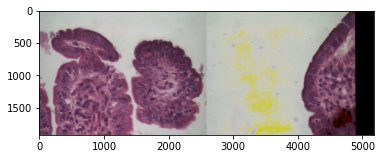

In [12]:
result = cv2.warpPerspective(imagenMatcheada, H,
      (imagenMatcheada.shape[1] + imagenA.shape[1], imagenMatcheada.shape[0]))
result[0:imagenA.shape[0], 0:imagenA.shape[1]] = imagenA
plt.imshow(result[...,::-1])

el resultado es impecable!!!! Que nivel maribel

# Lo mismo pero con transformaciones

In [13]:
%reset -f
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
imagenA = cv2.imread("Imagenes/Intestino curso/01.tif")
imagenB = cv2.imread("Imagenes/Intestino curso/02.tif")

descriptor = cv2.xfeatures2d.SURF_create()

(kpsA, featuresA) = descriptor.detectAndCompute(imagenA, mask=None)
(kpsB, featuresB) = descriptor.detectAndCompute(imagenB, mask=None)

ratio = 0.75

matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

# 
matches = []
for (m1, m2) in rawMatches:
    if m1.distance < m2.distance * ratio:
        matches.append((m1.trainIdx, m1.queryIdx))

toleranciaRansac = 4

keypointsAFloatA = np.float32([kp.pt for kp in kpsA])
keypointsAFloatB = np.float32([kp.pt for kp in kpsB])

if len(matches) > 4:
    ptsA = np.float32([keypointsAFloatA[i] for (_, i) in matches])
    ptsB = np.float32([keypointsAFloatB[i] for (i, _) in matches])
    (H, inliners) = cv2.findHomography(
        ptsB, ptsA, cv2.RANSAC, toleranciaRansac)
else:
    print("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")